# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [33]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [45]:
import pandas as pd
import numpy as np

In [23]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [25]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [26]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [27]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [28]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [29]:
df.head()

#need to numerically encode channel,trip type,route, origin

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [30]:
df = pd.get_dummies(df, columns=['booking_origin'])
df = pd.get_dummies(df, columns=['sales_channel'])
df = pd.get_dummies(df, columns=['trip_type'])
df = pd.get_dummies(df, columns=['route'])
df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,route_TGGXIY,route_TPETRZ,route_TPETWU,route_TPEURT,route_TPEVTE,route_TRZWUH,route_TRZXIY,route_TWUWUH,route_TWUXIY,route_URTXIY
0,2,262,19,7,6,1,0,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
1,1,112,20,3,6,0,0,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
2,2,243,22,17,3,1,1,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
3,1,96,31,4,6,0,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0
4,2,68,22,15,3,1,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X=df.drop(columns=['booking_complete'])
y=df['booking_complete']

In [50]:
#binary classification random forest
#Import random fosets and confusion matrix metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV




In [51]:
def test_train_samples(X,y):
  scaler = StandardScaler()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #70% training
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test


In [52]:
X_train, X_test, y_train, y_test = test_train_samples(X,y)
print(y_test)

6241     0
767      0
39272    0
15964    1
31112    0
        ..
31558    0
8372     0
37710    0
7952     0
32311    0
Name: booking_complete, Length: 15000, dtype: int64


In [36]:
def parameter_selection(X,y):
  X_train, X_test, y_train, y_test = test_train_samples(X,y)
        
  rf_dic={
    "n_estimators":[10,50,200,500], #will try out 32 parameter combinations
    "max_features": ["sqrt","log2"],
    "max_depth": [4,8,30,100]
    }
        
  rf = RandomForestClassifier()
  grid_search = GridSearchCV(estimator=rf,param_grid=rf_dic,cv=3)
  grid_search.fit(X_train,y_train)

  print("the best parameters are: " +str(grid_search.best_params_))

  n_est = grid_search.best_params_['n_estimators']
  m_depth = grid_search.best_params_['max_depth']
  m_feat = grid_search.best_params_['max_features']
  return n_est,m_depth,m_feat

n_est,m_depth,m_feat= parameter_selection(X,y)


the best parameters are: {'max_depth': 100, 'max_features': 'log2', 'n_estimators': 200}


In [53]:
def fit_model(X,y):
  X_train, X_test, y_train, y_test = test_train_samples(X,y)
  model = RandomForestClassifier(n_estimators =n_est, max_depth=m_depth, max_features=m_feat)
    
  # Train model
  trained_model = model.fit(X_train, y_train)

  # Generate predictions on test sample
  y_pred = trained_model.predict(X_test)
  #print(y_pred.shape)

  train_acc = trained_model.score(X_train, y_train)
  test_acc = trained_model.score(X_test, y_test)

  return  train_acc, test_acc, y_test, y_pred

In [54]:
#cross val
train_acc_K=[]
test_acc_K=[]
y_test_K=[]
y_pred_K=[]


for k in range (10):
  a,b,c,d = fit_model(X,y)
  print(f"Fold {k + 1}: testing acc = {b:.3f}")
  train_acc_K.append(a)
  test_acc_K.append(b)
  y_test_K += list(c)
  y_pred_K += list(d)

av_train = np.mean(train_acc_K)
av_test = np.mean(test_acc_K)

print('cross validated training accuracy:'+str(av_train*100))
print('cross validated testing accuracy:'+str(av_test*100))


Fold 1: testing acc = 0.851
Fold 2: testing acc = 0.855
Fold 3: testing acc = 0.853
Fold 4: testing acc = 0.851
Fold 5: testing acc = 0.854
Fold 6: testing acc = 0.855
Fold 7: testing acc = 0.853
Fold 8: testing acc = 0.854
Fold 9: testing acc = 0.851
Fold 10: testing acc = 0.851
cross validated training accuracy:96.67542857142857
cross validated testing accuracy:85.28466666666667


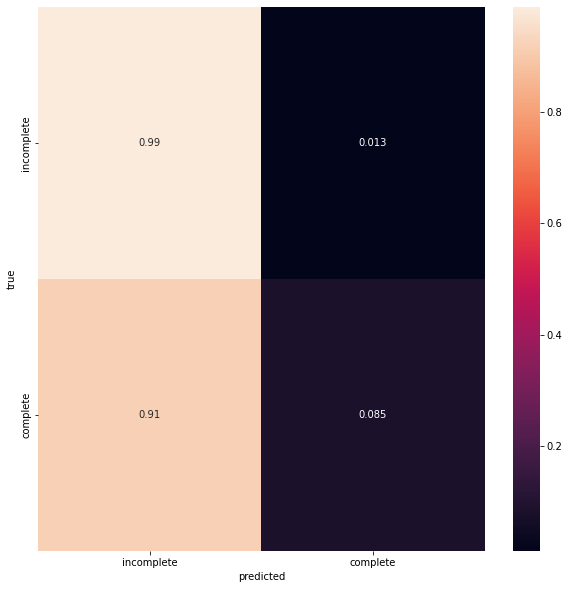

In [59]:
#cross validated confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_test_K,y_pred_K,normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(['incomplete','complete'])
ax.set_yticklabels(['incomplete','complete'])
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()

In [65]:
#feature importance

X_train, X_test, y_train, y_test = test_train_samples(X,y)
model = RandomForestClassifier(n_estimators =n_est, max_depth=m_depth, max_features=m_feat)

trained_model = model.fit(X_train, y_train)
y_pred = trained_model.predict(X_test)




TypeError: ignored

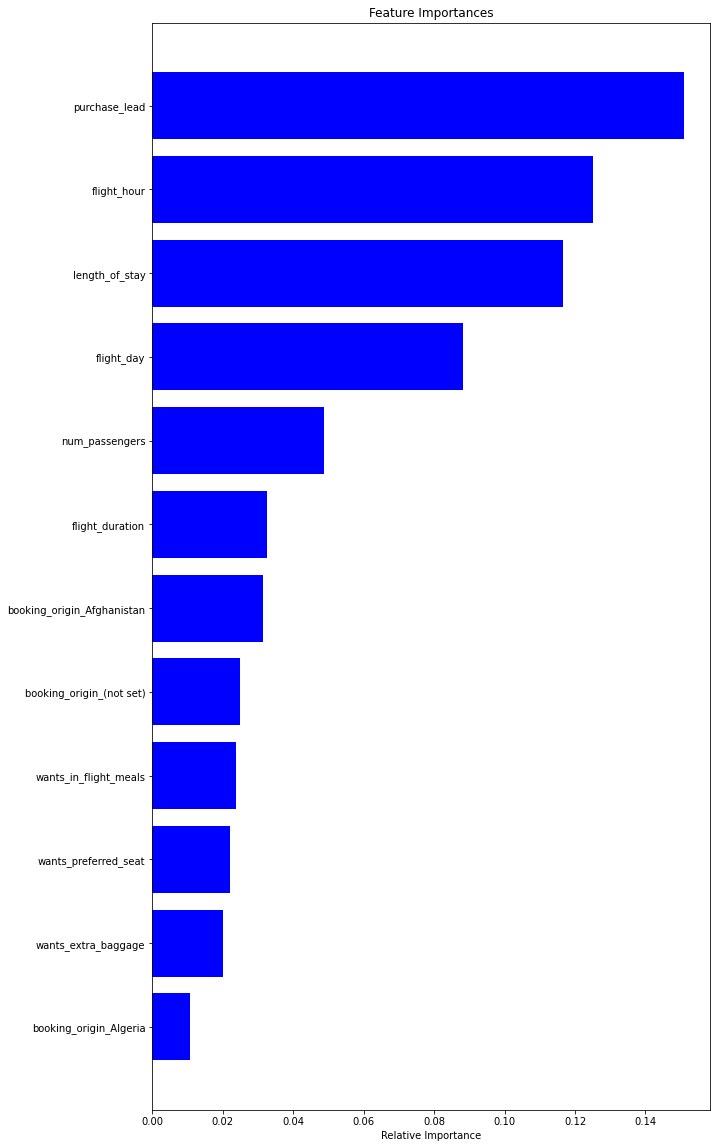

In [74]:
features = [i.split("__")[0] for i in X.columns]
importances = model.feature_importances_
#indices2 = np.sort(importances,acending=False)[:10]

importances=importances[importances>0.01]
indices = np.argsort(importances)

abundance = importances[indices]
label = [features[i] for i in indices]


fig, ax = plt.subplots(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(abundance)), abundance, color='b', align='center')
plt.yticks(range(len(abundance)), label)
plt.xlabel('Relative Importance')
plt.show()


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.